In [42]:

import heat_exchanger
from constants import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

In [43]:
df = pd.read_csv('2024designs.csv')
optdf = pd.read_csv('optimal_designs.csv')
optdf

,Cold Passes,Hot Passes,Tube Pattern,Tubes,Baffles,Length,Mdot cold,Mdot hot,Qdot,Effectiveness,Mass,Total Tube Length
0,1,1,Triangle,13,8,0.2678,0.5892,0.4778,12297,0.1446,1.0950,3.4814
1,1,1,Square,13,8,0.2678,0.5885,0.4778,12314,0.1450,1.0950,3.4814
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
3,1,2,Square,"6,6",8,0.2877,0.5928,0.4296,14123,0.2109,1.1000,3.4524
4,1,3,Triangle,"4,5,5",8,0.2470,0.5818,0.3685,14328,0.2524,1.0791,3.4580
5,1,3,Square,"5,5,5",8,0.2320,0.5755,0.3855,14336,0.2414,1.0759,3.4800
6,2,2,Triangle,"5,6","8,8",0.2900,0.5908,0.4174,13896,0.2106,1.0849,3.1900
7,2,2,Square,"6,6","8,7",0.2766,0.5902,0.4304,13901,0.2044,1.1000,3.3192
8,2,4,Triangle,"4,4,4,4","7,7",0.2173,0.5714,0.3209,14136,0.2828,1.0910,3.4768
9,2,4,Square,"4,4,4,4","7,7",0.2173,0.5728,0.3209,14103,0.2816,1.0910,3.4768


In [44]:
from optimiser import Scipy_Global_Optimise_Worker

def comptute_designs(df, set_fouling = False):
    mdot_colds = np.zeros(len(df))
    mdot_hots = np.zeros(len(df))
    Qdots = np.zeros(len(df))
    effs = np.zeros(len(df))
    masses = np.zeros(len(df))

    hot_passes = np.zeros(len(df))
    cold_passes = np.zeros(len(df))
    total_tubes = np.zeros(len(df))

    matching_optdf = pd.DataFrame(columns=optdf.columns)

    for i, row in enumerate(df.iterrows()):
        
        tubes = str(row[1]["Tubes"]).split(",")
        tubes = [int(t) for t in tubes]
        baffles = str(row[1]["Baffles"]).split(",")
        baffles = [int(b) for b in baffles]
        length = float(row[1]["Tube Length"])

        hot_passes[i] = len(tubes)
        cold_passes[i] = len(baffles)

        pattern_str = row[1]["Pattern"]
        pattern_str = pattern_str[0].upper() + pattern_str[1:].lower()

        matching_row = optdf[
            (optdf["Cold Passes"] == len(baffles)) &
            (optdf["Hot Passes"] == len(tubes)) &
            (optdf["Tube Pattern"] == pattern_str)
        ]
        matching_optdf = matching_optdf.append(matching_row)

        if pattern_str == "Square":
            pattern = Pattern.SQUARE
        elif pattern_str == "Triangle":
            pattern = Pattern.TRIANGLE
        
        HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
        if set_fouling:
            HX.set_conditions([20, 60], [Rf_water, Rf_water])
        else:
            HX.set_conditions([20, 60], [0, 0])
            
        HX.characteristic_year = row[1]["year"]

        result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")


        if not result:
            continue

        Qdots[i] = HX.Qdot
        effs[i] = HX.effectiveness
        masses[i] = HX.calc_mass()
        total_tubes[i] = HX.total_tubes * length
        mdot_colds[i] = HX.mdot[0]
        mdot_hots[i] = HX.mdot[1]
    
    return Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes, masses, total_tubes, matching_optdf


In [45]:


Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes, masses, total_tubes, matching_optdf = comptute_designs(df)
Qdots_fouling, effs_fouling, mdot_colds_fouling, mdot_hots_fouling, hot_passes_fouling, cold_passes_fouling, masses_fouling, total_tubes_fouling, matching_optdf_fouling = comptute_designs(df, set_fouling=True)
matching_optdf

C:\Users\louis\AppData\Local\Temp\ipykernel_22456\850218553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.append(matching_row)
C:\Users\louis\AppData\Local\Temp\ipykernel_22456\850218553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.append(matching_row)
C:\Users\louis\AppData\Local\Temp\ipykernel_22456\850218553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.append(matching_row)
C:\Users\louis\AppData\Local\Temp\ipykernel_22456\850218553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.a

,Cold Passes,Hot Passes,Tube Pattern,Tubes,Baffles,Length,Mdot cold,Mdot hot,Qdot,Effectiveness,Mass,Total Tube Length
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
6,2,2,Triangle,"5,6","8,8",0.2900,0.5908,0.4174,13896,0.2106,1.0849,3.1900
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
4,1,3,Triangle,"4,5,5",8,0.2470,0.5818,0.3685,14328,0.2524,1.0791,3.4580


In [46]:
print(masses)
print(total_tubes)
print(Qdots)

[1.07032843 1.01542843 1.14516843 1.0807566  1.0753905 ]
[3.336 3.12  3.48  3.5   3.495]
[13936.95903219 13628.01100783 14178.54991615 13586.26095946
 14217.74107976]


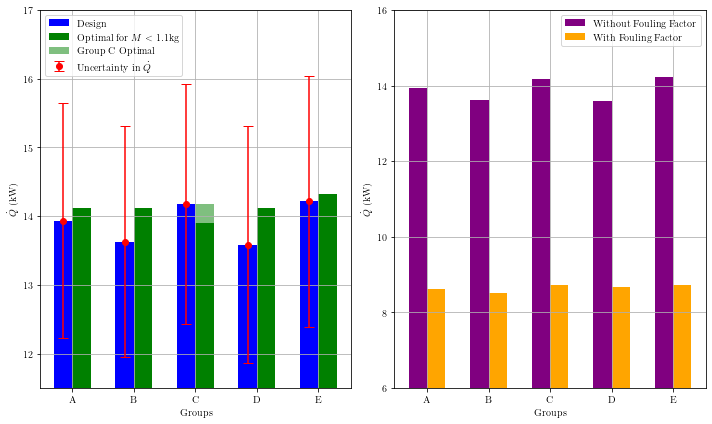

[0.38078018 0.37613867 0.38534946 0.36171972 0.38621907]
percent below our design  [1.97487101 4.14784647 0.27564972 4.44149402]
percent design below optimal design  2    1.338248
2    3.525336
6   -2.033318
2    3.820891
4    0.769535
Name: Qdot, dtype: object


In [47]:

# plot a bar chart

fig, ax = plt.subplots(1, 2)
groups = ["A", "B", "C", "D", "E"]

u_qdot_calcs = [0.12302294, 0.12346035, 0.12309175, 0.12693972, 0.12838717]
Qdot_TESTED = [
    11.83,
    10.89,
    12.34,
    14.77,
    13.33
]

# plot two dual bar charts for Qdot design and Qdot optimal design

bar_width = 0.3
bar_ticks = np.arange(len(groups))


ax[0].bar(bar_ticks, Qdots / 1e3, color = "blue", label = "Design", width = bar_width)
# plot errorbars
ax[0].bar(bar_ticks + bar_width, matching_optdf["Qdot"] / 1e3, color = "green", label = "Optimal for $M < 1.1$kg", width = bar_width)
ax[0].bar(bar_ticks[2] + bar_width, 14.178, color = "green", width = bar_width, label = "Group C Optimal", alpha = 0.5)
ax[0].errorbar(bar_ticks, Qdots / 1e3, u_qdot_calcs * Qdots / 1e3, fmt = "o", color = "red", label = "Uncertainty in $\dot{Q}$", capsize = 5)

ax[0].set_ylabel("$\dot{Q}$ (kW)")
ax[0].set_xlabel("Groups")
ax[0].set_ylim(11.5, 17)
# set group x labels
ax[0].set_xticks(bar_ticks + bar_width / 2)
ax[0].set_xticklabels(groups)
ax[0].legend(loc = "upper left")

ax[0].grid()


# plot two dual bar charts for effectiveness design and effectiveness optimal design
ax[1].bar(bar_ticks, Qdots / 1e3, color = "purple", label = "Without Fouling Factor", width = bar_width)
ax[1].bar(bar_ticks + bar_width, Qdots_fouling / 1e3, color = "orange", label = "With Fouling Factor", width = bar_width)

ax[1].set_ylabel("$\dot{Q}$ (kW)")
ax[1].set_xlabel("Groups")
ax[1].set_ylim(6, 16)
ax[1].set_xticks(bar_ticks + bar_width / 2)
ax[1].set_xticklabels(groups)
ax[1].legend()

ax[1].grid()

plt.tight_layout()

plt.savefig("2024comparison.png", dpi=300)
plt.show()

print(1 - Qdots_fouling / Qdots)
print("percent below our design ", 100 * (1 - Qdots[:4] / Qdots[4]))
print("percent design below optimal design ", 100 * (1 - Qdots / matching_optdf["Qdot"]))

In [48]:
# compare all designs with fouling factor
Qdots_fouling = np.zeros(len(df))
effs_fouling = np.zeros(len(df))

for i,row in enumerate(df.iterrows()):
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60], [Rf_water, Rf_water])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "E_NTU", optimiser="fsolve")
    print(result, HX.Qdot)

    if not result:
        continue

    Qdots_fouling[i] = HX.Qdot
    effs_fouling[i] = HX.effectiveness



True 8630.04123170449
True 8501.989103056074
True 8714.853362627427
True 8671.842393091716
True 8726.578346224249


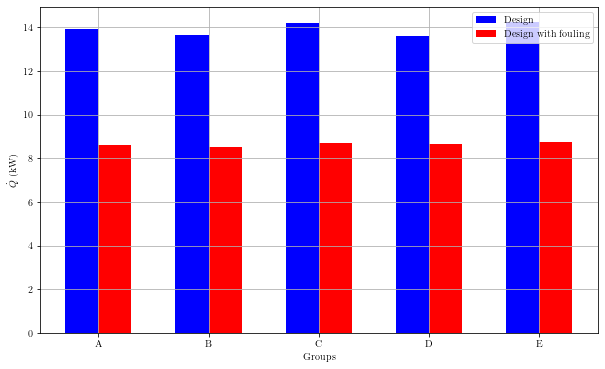

In [49]:

# right compare designs without fouling to with fouling

plt.figure()
bar_width = 0.3
bar_ticks = np.arange(len(groups))

plt.bar(bar_ticks, Qdots / 1e3, color = "blue", label = "Design", width = bar_width)
plt.bar(bar_ticks + bar_width, Qdots_fouling / 1e3, color = "red", label = "Design with fouling", width = bar_width)

plt.ylabel("$\dot{Q}$ (kW)")
plt.xlabel("Groups")

plt.xticks(bar_ticks + bar_width / 2, groups)
plt.legend()

plt.grid()


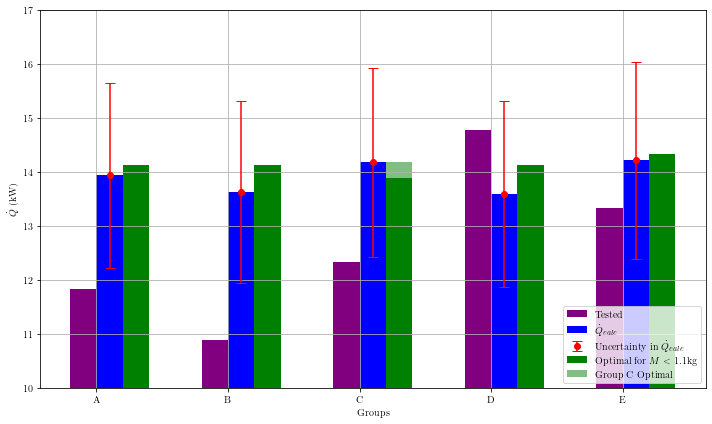

In [55]:

fig,ax = plt.subplots(1, 1)

groups = ["A", "B", "C", "D", "E"]

u_qdot_calcs = [0.12302294, 0.12346035, 0.12309175, 0.12693972, 0.12838717]
Qdot_TESTED = [
    11.83,
    10.89,
    12.34,
    14.77,
    13.33
]

# plot two dual bar charts for Qdot design and Qdot optimal design

bar_width = 0.2
bar_ticks = np.arange(len(groups))


ax.bar(bar_ticks, Qdot_TESTED, color = "purple", label = "Tested", width = bar_width)
ax.bar(bar_ticks + 1 * bar_width, Qdots / 1e3, color = "blue", label = r"$\dot{Q}_{calc}$", width = bar_width)
ax.errorbar(bar_ticks + 1 * bar_width, Qdots / 1e3, u_qdot_calcs * Qdots / 1e3, fmt = "o", color = "red", label = r"Uncertainty in $\dot{Q}_{calc}$", capsize = 5)
# plot errorbars
ax.bar(bar_ticks + 2 * bar_width, matching_optdf["Qdot"] / 1e3, color = "green", label = "Optimal for $M < 1.1$kg", width = bar_width)
ax.bar(bar_ticks[2] + 2 * bar_width, 14.178, color = "green", width = bar_width, label = "Group C Optimal", alpha = 0.5)

ax.set_ylabel("$\dot{Q}$ (kW)")
ax.set_xlabel("Groups")
ax.set_ylim(10, 17)
# set group x labels
ax.set_xticks(bar_ticks + bar_width / 2)
ax.set_xticklabels(groups)
ax.legend(loc = "lower right")

ax.grid()

plt.tight_layout()

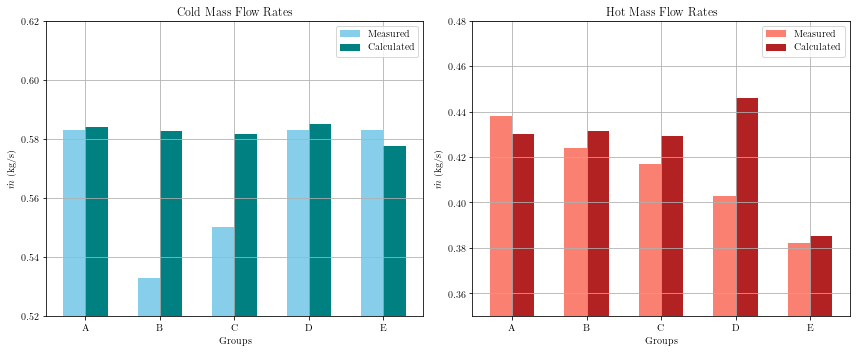

In [57]:

cold_measured = [
    0.583,
    0.533,
    0.550,
    0.583,
    0.583
]
hot_measured = [
    0.438,
    0.424,
    0.417,
    0.403,
    0.382
]

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

barwidth = 0.3
bar_ticks = np.arange(len(groups))

axes[0].bar(bar_ticks, cold_measured, color = "skyblue", label = "Measured", width = barwidth)
axes[0].bar(bar_ticks + barwidth, mdot_colds, color = "teal", label = "Calculated", width = barwidth)

axes[0].set_ylabel("$\dot{m}$ (kg/s)")
axes[0].set_xlabel("Groups")
axes[0].set_xticks(bar_ticks + barwidth / 2)
axes[0].set_xticklabels(groups)
axes[0].set_ylim(0.52, 0.62)

axes[0].legend()
axes[0].grid()
axes[0].set_title("Cold Mass Flow Rates")

axes[1].bar(bar_ticks, hot_measured, color = "salmon", label = "Measured", width = barwidth)
axes[1].bar(bar_ticks + barwidth, mdot_hots, color = "firebrick", label = "Calculated", width = barwidth)

axes[1].set_ylabel("$\dot{m}$ (kg/s)")
axes[1].set_xlabel("Groups")
axes[1].set_xticks(bar_ticks + barwidth / 2)
axes[1].set_xticklabels(groups)
axes[1].set_ylim(0.35, 0.48)

axes[1].legend()
axes[1].grid()
axes[1].set_title("Hot Mass Flow Rates")

plt.tight_layout()
plt.savefig("2024_mass_flow_rates", dpi=300)